In [4]:
from google.colab import files
uploaded = files.upload()


Saving Day2Data.csv to Day2Data.csv


In [5]:
from google.colab import files
uploaded = files.upload()


Saving Day2Data_with_QSI2.csv to Day2Data_with_QSI2.csv


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('Day2Data.csv')
df.head()

,Timestamp,ServingCellID,PCellRSRP,PCellRSRQ,NeighCellId,NeighCellRSRP,NeighCellRSRQ,Handover,CINRvalue1,CINRvalue2,CINR
0,46:26.3,50,51,6.0,77,49.0,6.0,0,11,9,10.0
1,46:26.3,50,51,6.0,162,47.0,4.0,0,11,9,10.0
2,46:28.4,50,52,10.0,77,46.0,2.0,0,11,9,10.0
3,46:38.9,50,48,4.0,77,47.0,7.0,0,1,-1,0.0
4,46:39.3,50,51,6.0,77,49.0,6.0,0,2,-4,-1.0


In [7]:
df["Handover"].value_counts()

,count
Handover,
0,553
1,94


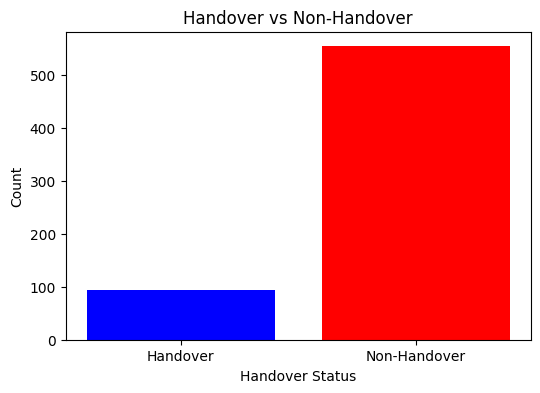

In [8]:
import matplotlib.pyplot as plt

# Data
categories = ['Handover', 'Non-Handover']
counts = [94, 553]

# Plotting the data
plt.figure(figsize=(6, 4))
plt.bar(categories, counts, color=['blue', 'red'])

# Adding labels and title
plt.xlabel('Handover Status')
plt.ylabel('Count')
plt.title('Handover vs Non-Handover')

# Display the plot
plt.show()


In [9]:
# Replace column names with expected ones
df.rename(columns={"PCellRSRP": "RSRP", "PCellRSRQ": "RSRQ", "CINR": "SNR"}, inplace=True)

# Function to calculate composite scores with weights
def calculate_composite_score(w_rsrp, w_rsrq, w_snr):
    return (w_rsrp * df['RSRP']) + (w_rsrq * df['RSRQ']) + (w_snr * df['SNR'])

# Define initial weights
weights = {'RSRP': 0.5, 'RSRQ': 0.5, 'SNR': 0.5}
best_accuracy = 0
best_weights = weights

# Grid search for best weights
for w_rsrp in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for w_rsrq in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        for w_snr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            if w_rsrp + w_rsrq + w_snr == 1:  # Ensure weights sum to 1
                df['Composite_Score'] = calculate_composite_score(w_rsrp, w_rsrq, w_snr)

                # Calculate thresholds
                excellent_threshold = df['Composite_Score'].quantile(0.9)
                good_threshold = df['Composite_Score'].quantile(0.5)
                moderate_threshold = df['Composite_Score'].quantile(0.15)

                # Label QSI categories
                def label_qsi(score):
                    if score >= excellent_threshold:
                        return "Excellent"
                    elif score >= good_threshold:
                        return "Good"
                    elif score >= moderate_threshold:
                        return "Moderate"
                    else:
                        return "Poor"

                df['QSI_Category'] = df['Composite_Score'].apply(label_qsi)

                # Prepare for logistic regression
                X = df[['RSRP', 'RSRQ', 'SNR']]
                y = df['QSI_Category']
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                # Train model
                model = LogisticRegression()
                model.fit(X_train, y_train)

                # Evaluate accuracy
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_weights = {'RSRP': w_rsrp, 'RSRQ': w_rsrq, 'SNR': w_snr}

# Calculate Composite Score with best weights
df['Composite_Score'] = calculate_composite_score(best_weights['RSRP'], best_weights['RSRQ'], best_weights['SNR'])


# Calculate thresholds
excellent_threshold = df['Composite_Score'].quantile(0.9)
good_threshold = df['Composite_Score'].quantile(0.5)
moderate_threshold = df['Composite_Score'].quantile(0.15)

# Label QSI categories again using best weights
def label_qsi(score):
    if score >= excellent_threshold:
        return "Excellent"
    elif score >= good_threshold:
        return "Good"
    elif score >= moderate_threshold:
        return "Moderate"
    else:
        return "Poor"

df['QSI_Category'] = df['Composite_Score'].apply(label_qsi)

# Output the results
print(f"Best Weights: {best_weights}")
print(f"Best Accuracy: {best_accuracy}")
# Save the dataset with QSI scores and categories
df.to_csv('Day2Data_with_QSI2.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Weights: {'RSRP': 0.5, 'RSRQ': 0.2, 'SNR': 0.3}
Best Accuracy: 0.9923076923076923


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [10]:
df = pd.read_csv('Day2Data_with_QSI2.csv')
df.head(10)

,Timestamp,ServingCellID,RSRP,RSRQ,NeighCellId,NeighCellRSRP,NeighCellRSRQ,Handover,CINRvalue1,CINRvalue2,SNR,Composite_Score,QSI_Category
0,46:26.3,50,51,6.0,77,49.0,6.00,0,11,9,10.0,29.70,Good
1,46:26.3,50,51,6.0,162,47.0,4.00,0,11,9,10.0,29.70,Good
2,46:28.4,50,52,10.0,77,46.0,2.00,0,11,9,10.0,31.00,Good
3,46:38.9,50,48,4.0,77,47.0,7.00,0,1,-1,0.0,24.80,Moderate
4,46:39.3,50,51,6.0,77,49.0,6.00,0,2,-4,-1.0,26.40,Moderate
5,46:39.3,50,51,6.0,162,47.0,4.00,0,2,-4,-1.0,26.40,Moderate
6,46:40.2,50,48,5.0,77,50.0,10.25,0,-1,-4,-2.5,24.25,Moderate
7,46:40.4,50,49,3.0,77,55.0,14.50,1,-1,-4,-2.5,24.35,Moderate
8,46:42.0,50,60,14.0,77,52.0,18.75,1,-1,-4,-2.5,32.05,Good
9,46:43.2,77,50,23.0,50,52.0,25.00,0,7,9,8.0,32.00,Good


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
file_path = "Day2Data_with_QSI2.csv"
df = pd.read_csv(file_path)

# Encode the QSI_Category column
label_mapping = {"Excellent": 0, "Good": 1, "Moderate": 2, "Poor": 3}
df["QSI_Category"] = df["QSI_Category"].map(label_mapping)

# Select features and target
X = df[["RSRP", "RSRQ", "SNR"]]
y = df["QSI_Category"]

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train logistic regression model
model = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs")
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.9923
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        52
           2       0.98      1.00      0.99        45
           3       1.00      0.95      0.97        20

    accuracy                           0.99       130
   macro avg       0.99      0.99      0.99       130
weighted avg       0.99      0.99      0.99       130



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
file_path = "Day2Data_with_QSI2.csv"
df = pd.read_csv(file_path)

# Encode the QSI_Category column
label_mapping = {"Excellent": 0, "Good": 1, "Moderate": 2, "Poor": 3}
df["QSI_Category"] = df["QSI_Category"].map(label_mapping)

# Select features and target
X = df[["RSRP", "RSRQ", "SNR"]]
y = df["QSI_Category"]

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", n_estimators=100)
}

# Train and evaluate models
for name, model in models.items():
    print(f"\n{name} Results:")
    if name == "K-Nearest Neighbors":
        model.fit(X_train, y_train)  # Use scaled data for KNN
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)



Random Forest Results:
Accuracy: 0.9385
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.93      0.96      0.94        52
           2       0.91      0.93      0.92        45
           3       1.00      0.90      0.95        20

    accuracy                           0.94       130
   macro avg       0.96      0.93      0.94       130
weighted avg       0.94      0.94      0.94       130


K-Nearest Neighbors Results:
Accuracy: 0.9385
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.91      0.98      0.94        52
           2       0.93      0.91      0.92        45
           3       1.00      0.90      0.95        20

    accuracy                           0.94       130
   macro avg       0.96      0.93      0.94       130
weighted avg       0.94      0.94      0.94      

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:02:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("Day2Data_with_QSI2.csv")

# Encode QSI_Category
label_mapping = {"Excellent": 0, "Good": 1, "Moderate": 2, "Poor": 3}
df["QSI_Category"] = df["QSI_Category"].map(label_mapping)

# Features & Target
X = df[["RSRP", "RSRQ", "SNR"]]
y = df["QSI_Category"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train AdaBoost model
model = AdaBoostClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7000
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.73      0.86      0.79        50
           2       0.69      0.89      0.78        47
           3       0.75      0.30      0.43        20

    accuracy                           0.70       130
   macro avg       0.54      0.51      0.50       130
weighted avg       0.64      0.70      0.65       130



In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("Day2Data_with_QSI2.csv")

# Encode QSI_Category
label_mapping = {"Excellent": 0, "Good": 1, "Moderate": 2, "Poor": 3}
df["QSI_Category"] = df["QSI_Category"].map(label_mapping)

# Features & Target
X = df[["RSRP", "RSRQ", "SNR"]]
y = df["QSI_Category"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train SVM model
model = SVC(kernel='linear', probability=True, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9923
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.98      0.99        52
           2       1.00      1.00      1.00        45
           3       1.00      1.00      1.00        20

    accuracy                           0.99       130
   macro avg       0.98      1.00      0.99       130
weighted avg       0.99      0.99      0.99       130



In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("Day2Data_with_QSI2.csv")

# Encode QSI_Category
label_mapping = {"Excellent": 0, "Good": 1, "Moderate": 2, "Poor": 3}
df["QSI_Category"] = df["QSI_Category"].map(label_mapping)

# Features & Target
X = df[["RSRP", "RSRQ", "SNR"]]
y = df["QSI_Category"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize data for Naïve Bayes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Naïve Bayes model
model = GaussianNB()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8692
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.62      0.76        13
           1       0.85      0.90      0.88        52
           2       0.82      0.93      0.88        45
           3       1.00      0.80      0.89        20

    accuracy                           0.87       130
   macro avg       0.92      0.81      0.85       130
weighted avg       0.88      0.87      0.87       130



In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("Day2Data_with_QSI2.csv")

# Encode QSI_Category
label_mapping = {"Excellent": 0, "Good": 1, "Moderate": 2, "Poor": 3}
df["QSI_Category"] = df["QSI_Category"].map(label_mapping)

# Features & Target
X = df[["RSRP", "RSRQ", "SNR"]]
y = df["QSI_Category"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Decision Tree model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8846
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.90      0.87      0.88        52
           2       0.84      0.91      0.87        45
           3       1.00      0.85      0.92        20

    accuracy                           0.88       130
   macro avg       0.90      0.89      0.89       130
weighted avg       0.89      0.88      0.89       130



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.9923
Random Forest Accuracy: 0.9385
KNN Accuracy: 0.9385
Gradient Boost Accuracy: 0.9385
XGBoost Accuracy: 0.9231


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:02:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AdaBoost Accuracy: 0.6923
Decision Tree Accuracy: 0.8846
Naïve Bayes Accuracy: 0.8692
SVM Accuracy: 0.9923


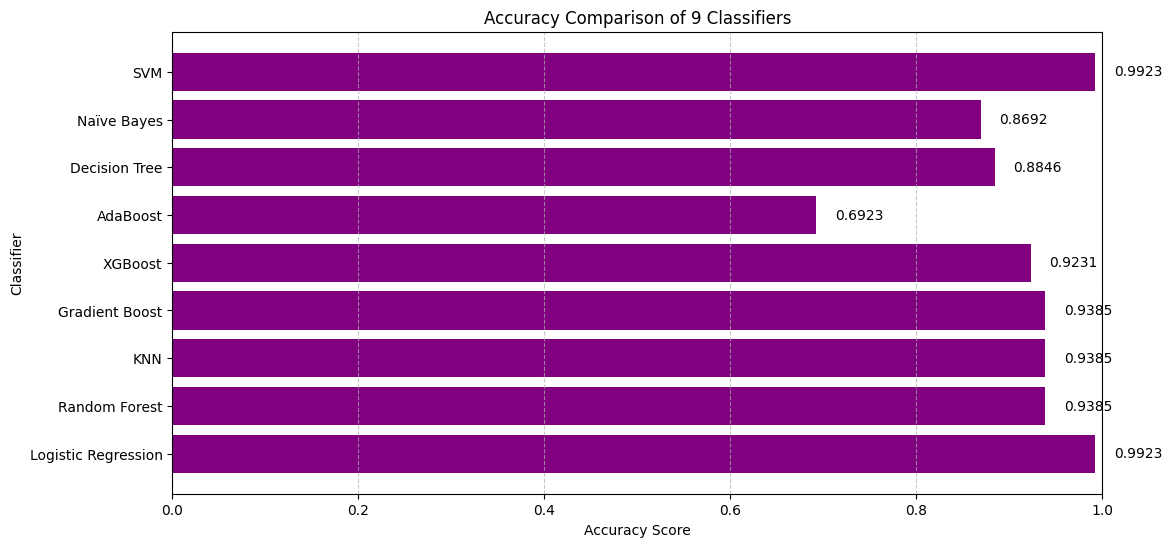

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv("Day2Data_with_QSI2.csv")

# Encode QSI_Category
label_mapping = {"Excellent": 0, "Good": 1, "Moderate": 2, "Poor": 3}
df["QSI_Category"] = df["QSI_Category"].map(label_mapping)

# Features & Target
X = df[["RSRP", "RSRQ", "SNR"]]
y = df["QSI_Category"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Dictionary of classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boost": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naïve Bayes": GaussianNB(),
    "SVM": SVC(kernel='linear', probability=True, random_state=42)
}

# Store accuracy scores
accuracy_scores = {}

# Train and evaluate each classifier
for name, model in classifiers.items():
    if name in ["Logistic Regression", "KNN", "Naïve Bayes", "SVM"]:
        model.fit(X_train, y_train)  # Use scaled data
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train, y_train)  # Use unscaled data
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

# Plot the accuracy scores
plt.figure(figsize=(12, 6))
plt.barh(list(accuracy_scores.keys()), list(accuracy_scores.values()), color='purple')
plt.xlabel("Accuracy Score")
plt.ylabel("Classifier")
plt.title("Accuracy Comparison of 9 Classifiers")
plt.xlim(0, 1)  # Accuracy range from 0 to 1
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display accuracy values on bars
for index, value in enumerate(accuracy_scores.values()):
    plt.text(value + 0.02, index, f"{value:.4f}", va='center', fontsize=10)

plt.show()

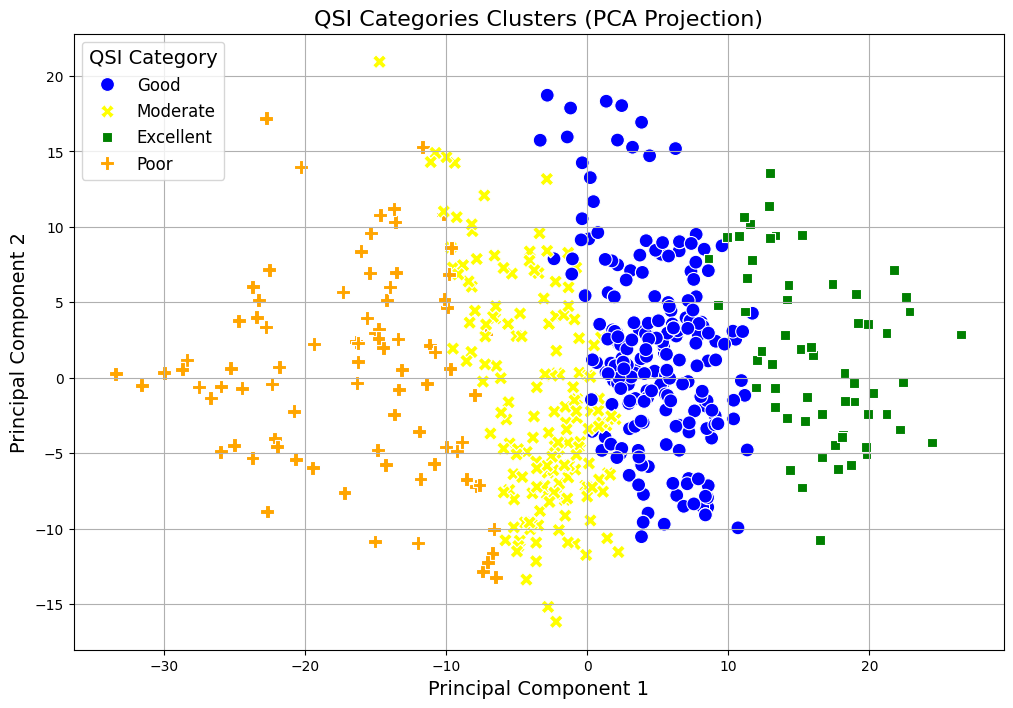

In [18]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Day2Data_with_QSI2.csv')

# Select the features for PCA
features = ['RSRP', 'RSRQ', 'SNR']

# Perform PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[features])
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

# Define a color palette for the categories
palette = {
    'Excellent': 'green',
    'Good': 'blue',
    'Moderate': 'yellow',
    'Poor': 'orange',
}

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='PCA1',
    y='PCA2',
    hue='QSI_Category',
    palette=palette,
    style='QSI_Category',
    s=100
)

# Add labels, title, and legend
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.title('QSI Categories Clusters (PCA Projection)', fontsize=16)
plt.legend(title='QSI Category', fontsize=12, title_fontsize=14, loc='upper left')
plt.grid(True)

# Save and display the plot

plt.show()


Centroids for each QSI_Category:
                   PCA1      PCA2
QSI_Category                     
Excellent     16.042605  1.767194
Good           4.831206  1.473416
Moderate      -3.204059 -2.391944
Poor         -16.350566  0.374912


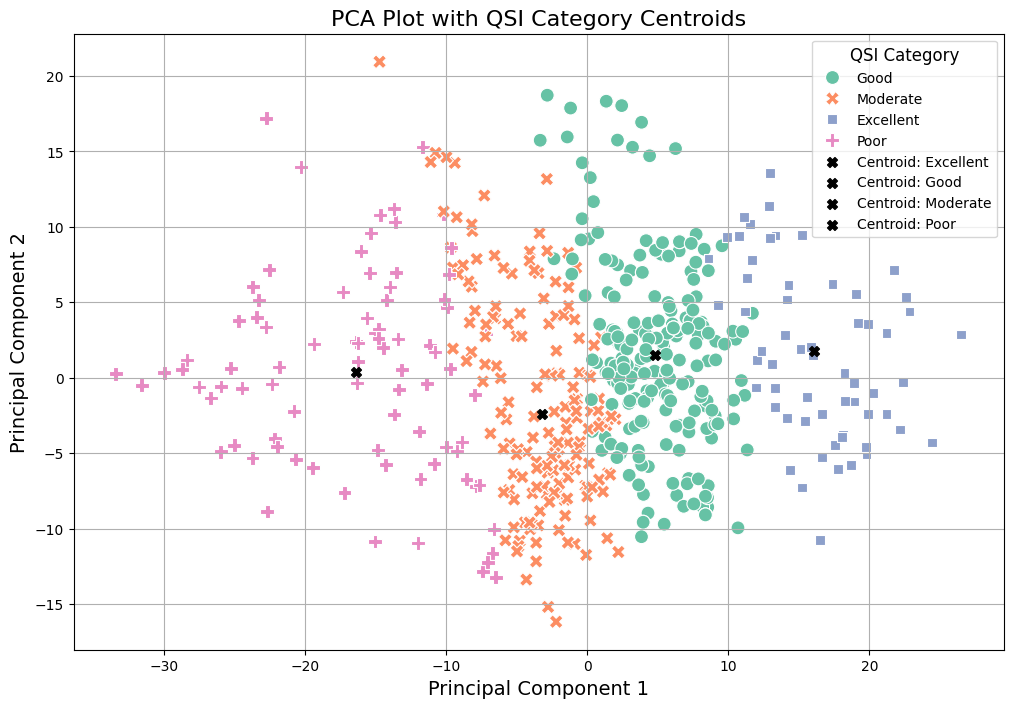

In [19]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Day2Data_with_QSI2.csv')

# Select the features for PCA
features = ['RSRP', 'RSRQ', 'SNR']

# Perform PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[features])
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

# Calculate centroids for each QSI_Category
centroids = df.groupby('QSI_Category')[['PCA1', 'PCA2']].mean()

# Display the centroids
print("Centroids for each QSI_Category:")
print(centroids)

# Plot the PCA results with centroids
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='PCA1',
    y='PCA2',
    hue='QSI_Category',
    palette='Set2',
    style='QSI_Category',
    s=100
)

# Plot centroids
for category, (x, y) in centroids.iterrows():
    plt.scatter(x, y, color='black', marker='X', s=50, label=f'Centroid: {category}')

# Add labels and title
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.title('PCA Plot with QSI Category Centroids', fontsize=16)
plt.legend(title='QSI Category', fontsize=10, title_fontsize=12, loc='best')
plt.grid(True)

# Show plot
plt.show()


Centroids for each QSI_Category:
                   PCA1      PCA2
QSI_Category                     
Excellent     15.560957  1.506622
Good           4.849614  1.032289
Moderate      -2.746731 -3.427674
Poor         -14.790149  0.557767


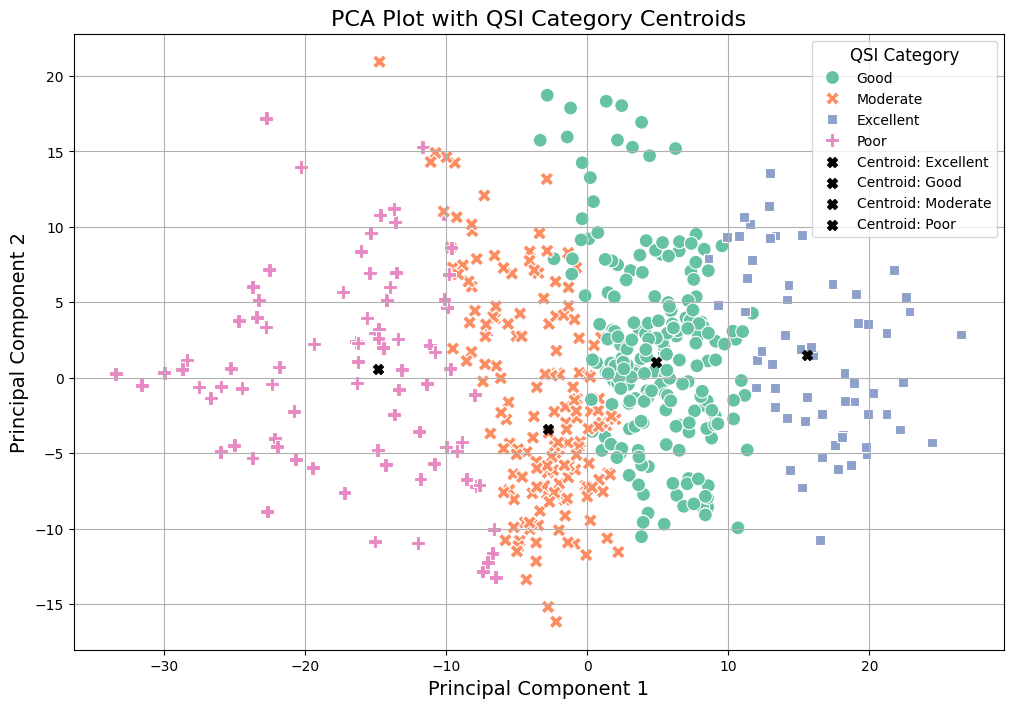

In [20]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Day2Data_with_QSI2.csv')

# Select the features for PCA
features = ['RSRP', 'RSRQ', 'SNR']

# Perform PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[features])
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

# Calculate centroids for each QSI_Category
centroids = df.groupby('QSI_Category')[['PCA1', 'PCA2']].median()

# Display the centroids
print("Centroids for each QSI_Category:")
print(centroids)

# Plot the PCA results with centroids
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='PCA1',
    y='PCA2',
    hue='QSI_Category',
    palette='Set2',
    style='QSI_Category',
    s=100
)

# Plot centroids
for category, (x, y) in centroids.iterrows():
    plt.scatter(x, y, color='black', marker='X', s=50, label=f'Centroid: {category}')

# Add labels and title
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.title('PCA Plot with QSI Category Centroids', fontsize=16)
plt.legend(title='QSI Category', fontsize=10, title_fontsize=12, loc='best')
plt.grid(True)

# Show plot
plt.show()


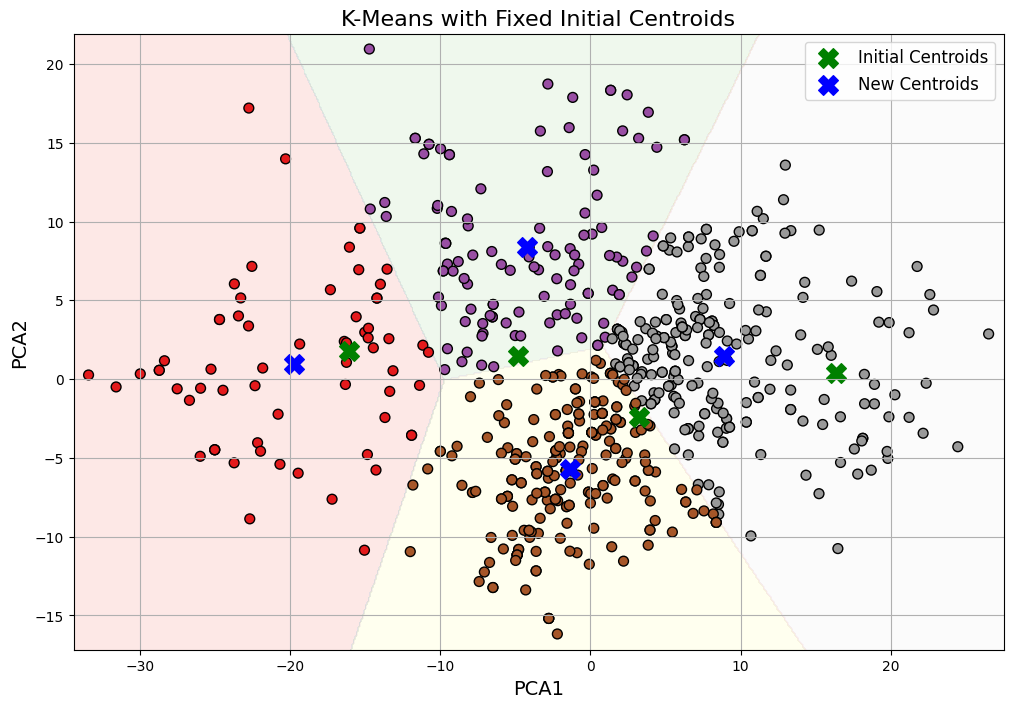

In [21]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('Day2Data_with_QSI2.csv')

# Select the features for PCA
features = ['RSRP', 'RSRQ', 'SNR']

# Perform PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[features])
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

# Extract PCA data
data = df[['PCA1', 'PCA2']].values


# Manually specified initial centroids based on the given QSI categories
initial_centroids = np.array([
    [-16.042605,  1.767194],    # Excellent
    [-4.831206,  1.473416],     # Good
    [ 3.204059, -2.391944],     # Moderate
    [16.350566,  0.374912],     # Poor
])


# Perform KMeans with fixed centroids
kmeans = KMeans(
    n_clusters=4,
    init=initial_centroids,
    max_iter=200,
    random_state=42
)
kmeans.fit(data)

# Add cluster assignments to the dataset
df['Cluster'] = kmeans.labels_

# Map clusters to categories
cluster_to_category = {
    3: 'Poor',
    2: 'Moderate',
    1: 'Good',
    0: 'Excellent'
}
df['Category'] = df['Cluster'].map(cluster_to_category)

# Save the updated dataset
df.to_csv('Day2Data_with_ClustersPPP.csv', index=False)

# Plot decision boundaries
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Pastel1')
plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels_, cmap='Set1', edgecolor='k', s=50)
plt.scatter(initial_centroids[:, 0], initial_centroids[:, 1], c='green', marker='X', s=200, label='Initial Centroids')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='blue', marker='X', s=200, label='New Centroids')
plt.xlabel('PCA1', fontsize=14)
plt.ylabel('PCA2', fontsize=14)
plt.title('K-Means with Fixed Initial Centroids', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [22]:
import pandas as pd

# Load the dataset with clusters and QSI categories
df = pd.read_csv('Day2Data_with_ClustersPPP.csv')

# Ensure that both 'Category' and 'QSI_Category' columns are present
categories = ['Poor', 'Moderate', 'Good', 'Excellent']

# Initialize a dictionary to store the match counts for each category
match_counts = {category: {'correct': 0, 'total': 0} for category in categories}

# Compare the 'Category' and 'QSI_Category' columns
for category in categories:
    # Get the subset of data for the current category
    category_data = df[df['QSI_Category'] == category]

    # Count the number of times the predicted 'Category' matches the actual 'QSI_Category'
    correct_matches = (category_data['Category'] == category).sum()

    # Update match counts
    match_counts[category]['correct'] = correct_matches
    match_counts[category]['total'] = len(category_data)

# Calculate the accuracy for each category
accuracy_per_category = {category: match_counts[category]['correct'] / match_counts[category]['total']
                         for category in categories}

# Print the accuracy for each category
for category in categories:
    correct = match_counts[category]['correct']
    total = match_counts[category]['total']
    accuracy = accuracy_per_category[category]
    print(f"{category}: {correct}/{total} correct, Accuracy: {accuracy * 100:.2f}%")


Poor: 0/97 correct, Accuracy: 0.00%
Moderate: 162/224 correct, Accuracy: 72.32%
Good: 36/261 correct, Accuracy: 13.79%
Excellent: 0/65 correct, Accuracy: 0.00%


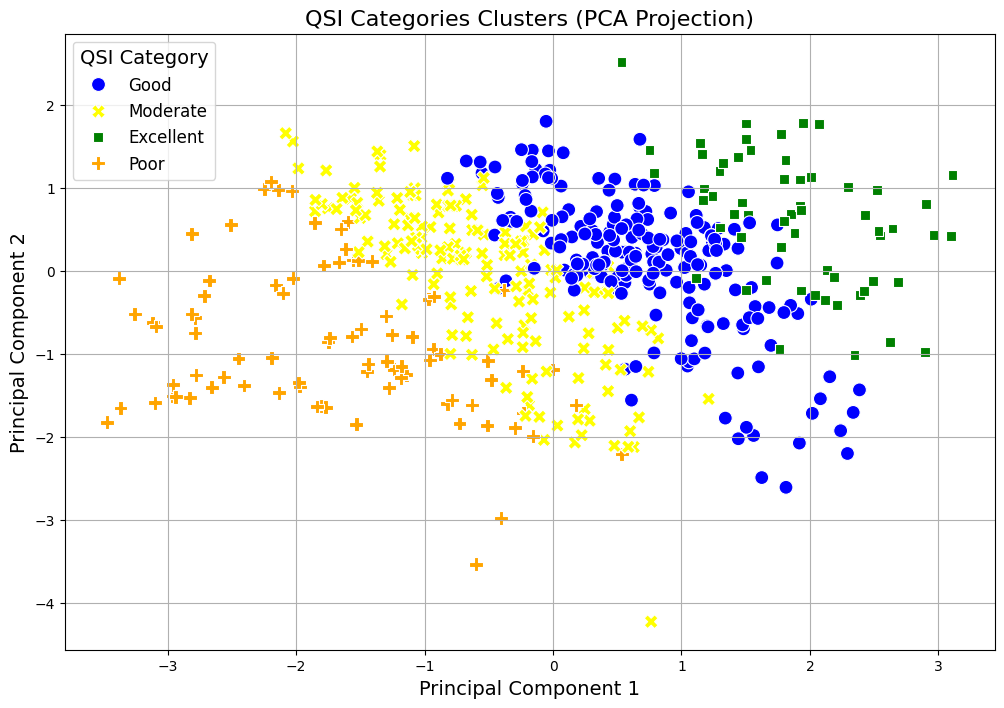

In [23]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Day2Data_with_QSI2.csv')

# Select the features for PCA
features = ['RSRP', 'RSRQ', 'SNR']

# Scale the features using StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

# Perform PCA on the scaled data
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Add the PCA results to the dataframe
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

# Define a color palette for the categories
palette = {
    'Excellent': 'green',
    'Good': 'blue',
    'Moderate': 'yellow',
    'Poor': 'orange',
}

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='PCA1',
    y='PCA2',
    hue='QSI_Category',
    palette=palette,
    style='QSI_Category',
    s=100
)

# Add labels, title, and legend
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.title('QSI Categories Clusters (PCA Projection)', fontsize=16)
plt.legend(title='QSI Category', fontsize=12, title_fontsize=14, loc='upper left')
plt.grid(True)

# Save and display the plot
plt.show()


Centroids for each QSI_Category:
                  PCA1      PCA2
QSI_Category                    
Excellent     1.880470  0.689649
Good          0.638983  0.178594
Moderate     -0.650780  0.263136
Poor         -1.649552 -1.070698


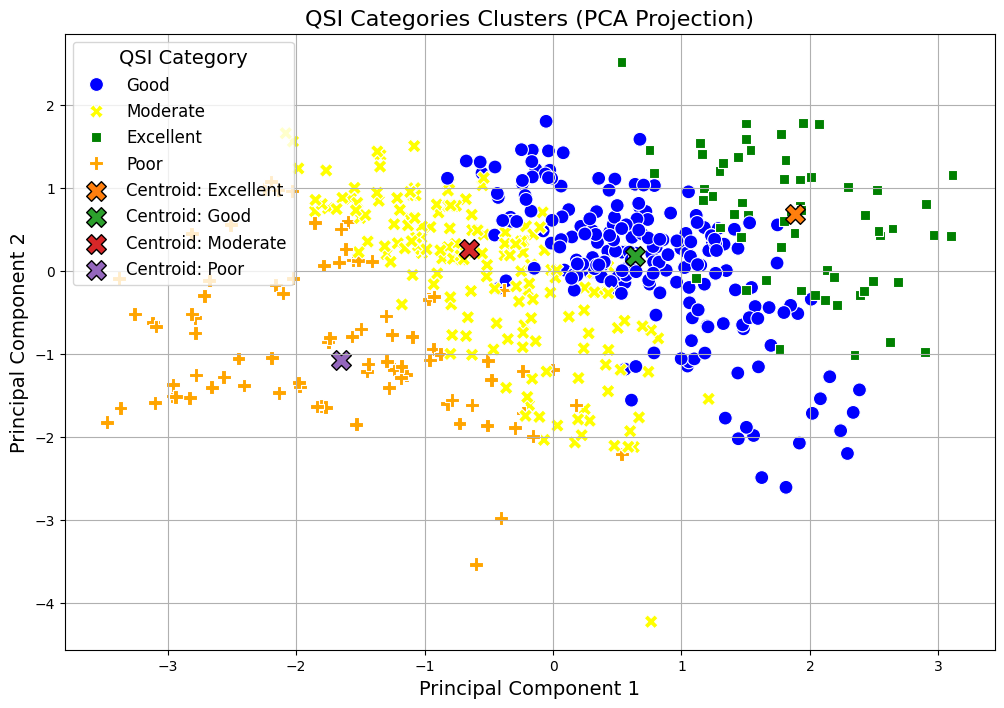

In [24]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Day2Data_with_QSI2.csv')

# Select the features for PCA
features = ['RSRP', 'RSRQ', 'SNR']

# Scale the features using StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

# Perform PCA on the scaled data
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Add the PCA results to the dataframe
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

# Calculate the centroids for each QSI_Category by taking the mean of PCA1 and PCA2
centroids = df.groupby('QSI_Category')[['PCA1', 'PCA2']].median()

# Print the centroids
print("Centroids for each QSI_Category:")
print(centroids)

# Define a color palette for the categories
palette = {
    'Excellent': 'green',
    'Good': 'blue',
    'Moderate': 'yellow',
    'Poor': 'orange',
}

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='PCA1',
    y='PCA2',
    hue='QSI_Category',
    palette=palette,
    style='QSI_Category',
    s=100
)

# Plot the centroids
for category, centroid in centroids.iterrows():
    plt.scatter(centroid['PCA1'], centroid['PCA2'], label=f'Centroid: {category}', s=200, marker='X', edgecolor='black')

# Add labels, title, and legend
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.title('QSI Categories Clusters (PCA Projection)', fontsize=16)
plt.legend(title='QSI Category', fontsize=12, title_fontsize=14, loc='upper left')
plt.grid(True)

# Save and display the plot
plt.show()


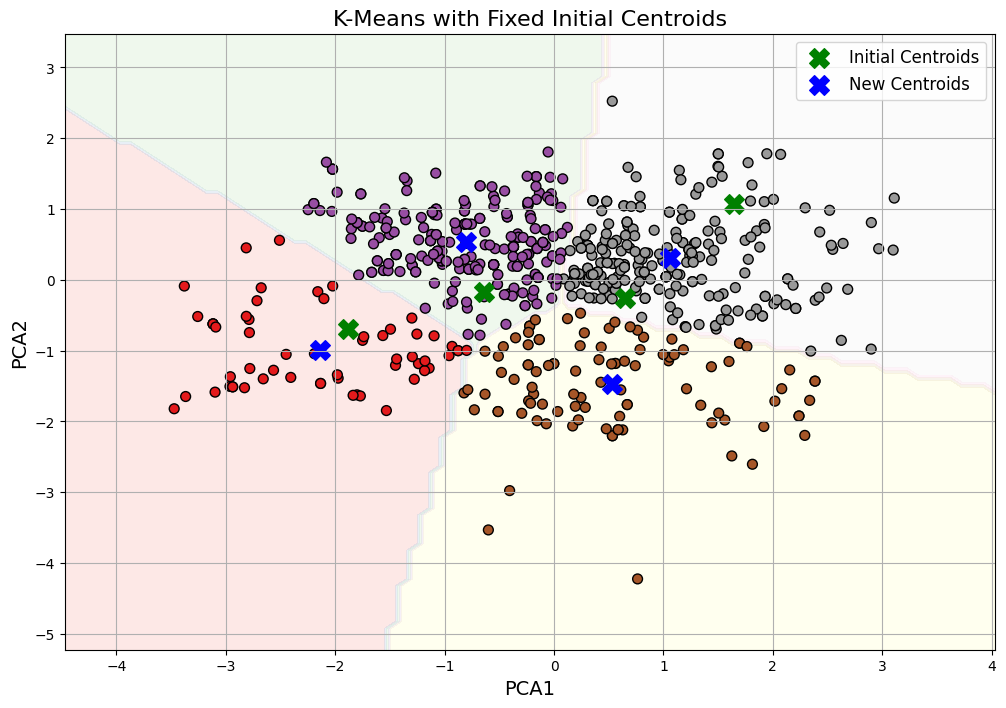

In [25]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('Day2Data_with_QSI2.csv')

# Select the features for PCA
features = ['RSRP', 'RSRQ', 'SNR']

# Scale the features using StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

# Perform PCA on the scaled data
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Add the PCA results to the dataframe
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

# Extract PCA data
data = df[['PCA1', 'PCA2']].values

initial_centroids = np.array([
    [-1.880470, -0.689649],   # Excellent
    [-0.638983, -0.178594],   # Good
    [ 0.650780, -0.263136],   # Moderate
    [ 1.649552,  1.070698],   # Poor
])

# Perform KMeans with fixed initial centroids
kmeans = KMeans(
    n_clusters=4,
    init=initial_centroids,
    max_iter=200,
    random_state=42
)
kmeans.fit(data)

# Add cluster assignments to the dataset
df['Cluster'] = kmeans.labels_

# Map clusters to categories
cluster_to_category = {
    3: 'Poor',
    2: 'Moderate',
    1: 'Good',
    0: 'Excellent'
}
df['Category'] = df['Cluster'].map(cluster_to_category)

# Save the updated dataset
df.to_csv('Day2Data_with_ClustersPPP.csv', index=False)

# Plot decision boundaries
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Pastel1')
plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels_, cmap='Set1', edgecolor='k', s=50)
plt.scatter(initial_centroids[:, 0], initial_centroids[:, 1], c='green', marker='X', s=200, label='Initial Centroids')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='blue', marker='X', s=200, label='New Centroids')
plt.xlabel('PCA1', fontsize=14)
plt.ylabel('PCA2', fontsize=14)
plt.title('K-Means with Fixed Initial Centroids', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [26]:
import pandas as pd

# Load the dataset with clusters and QSI categories
df = pd.read_csv('Day2Data_with_ClustersPPP.csv')

# Ensure that both 'Category' and 'QSI_Category' columns are present
categories = ['Poor', 'Moderate', 'Good', 'Excellent']

# Initialize a dictionary to store the match counts for each category
match_counts = {category: {'correct': 0, 'total': 0} for category in categories}

# Compare the 'Category' and 'QSI_Category' columns
for category in categories:
    # Get the subset of data for the current category
    category_data = df[df['QSI_Category'] == category]

    # Count the number of times the predicted 'Category' matches the actual 'QSI_Category'
    correct_matches = (category_data['Category'] == category).sum()

    # Update match counts
    match_counts[category]['correct'] = correct_matches
    match_counts[category]['total'] = len(category_data)

# Calculate the accuracy for each category
accuracy_per_category = {category: match_counts[category]['correct'] / match_counts[category]['total']
                         for category in categories}

# Print the accuracy for each category
for category in categories:
    correct = match_counts[category]['correct']
    total = match_counts[category]['total']
    accuracy = accuracy_per_category[category]
    print(f"{category}: {correct}/{total} correct, Accuracy: {accuracy * 100:.2f}%")


Poor: 0/97 correct, Accuracy: 0.00%
Moderate: 48/224 correct, Accuracy: 21.43%
Good: 52/261 correct, Accuracy: 19.92%
Excellent: 0/65 correct, Accuracy: 0.00%


In [29]:
# prompt: now, using the above training, for each model, creatyer a code that ask me for input and then gives the output for every model, the code must show result for every model separetely, not 1,2, but good, moderate etc etc.

import pandas as pd
import numpy as np

# Load the dataset (assuming 'Day2Data_with_QSI2.csv' is already in the runtime)
df = pd.read_csv('Day2Data_with_QSI2.csv')

# Function to predict QSI category based on input values and a model
def predict_qsi(rsrp, rsrq, snr, model):
    input_data = np.array([[rsrp, rsrq, snr]])
    prediction = model.predict(input_data)[0]
    return prediction

# Load your trained models (replace with your actual model loading code)

# Logistic Regression (Example - You need to load your actual model)
# ... load the logistic regression model ...

# Random Forest (Example - You need to load your actual model)
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)  # Assuming X_train and y_train are defined

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)


#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gradient_boosting_model.fit(X_train, y_train)


# XGBoost
from xgboost import XGBClassifier
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", n_estimators=100)
xgboost_model.fit(X_train, y_train)

# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_model.fit(X_train, y_train)

# SVM
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train,y_train)

# GaussianNB
from sklearn.naive_bayes import GaussianNB
gaussian_nb_model = GaussianNB()
gaussian_nb_model.fit(X_train, y_train)

# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)


# Example usage
while True:
    try:
        rsrp = float(input("Enter RSRP value: "))
        rsrq = float(input("Enter RSRQ value: "))
        snr = float(input("Enter SNR value: "))
        break
    except ValueError:
        print("Invalid input. Please enter numeric values.")


models_to_test = {
    "Logistic Regression": model,
    "Random Forest": random_forest_model,
    "K-Nearest Neighbors": knn_model,
    "Gradient Boosting": gradient_boosting_model,
    "XGBoost": xgboost_model,
    "AdaBoost": adaboost_model,
    "SVM": svm_model,
    "Naïve Bayes": gaussian_nb_model,
    "Decision Tree": decision_tree_model
}

# Mapping numerical predictions to QSI categories
label_mapping_reverse = {0: "Excellent", 1: "Good", 2: "Moderate", 3: "Poor"}

for model_name, model in models_to_test.items():
    predicted_value = predict_qsi(rsrp, rsrq, snr, model)
    qsi_category = label_mapping_reverse.get(predicted_value, "Unknown") # Handle potential KeyError
    print(f"{model_name}: {qsi_category}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:07:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Enter RSRP value: 51
Enter RSRQ value: 6
Enter SNR value: 10
Logistic Regression: Good
Random Forest: Good
K-Nearest Neighbors: Good
Gradient Boosting: Good
XGBoost: Good
AdaBoost: Good
SVM: Good
Naïve Bayes: Moderate
Decision Tree: Good


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-

In [30]:
# prompt: now i want to deploy it, genertae necessary pickel file for this

import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


# Assuming X_train and y_train are defined from your previous code
# ... your existing code to load data and split into X_train, y_train ...


# Logistic Regression
model = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs")
model.fit(X_train, y_train)
pickle.dump(model, open('logistic_regression_model.pkl', 'wb'))


# Random Forest
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)
pickle.dump(random_forest_model, open('random_forest_model.pkl', 'wb'))


# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
pickle.dump(knn_model, open('knn_model.pkl', 'wb'))


# Gradient Boosting
gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gradient_boosting_model.fit(X_train, y_train)
pickle.dump(gradient_boosting_model, open('gradient_boosting_model.pkl', 'wb'))


# XGBoost
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", n_estimators=100)
xgboost_model.fit(X_train, y_train)
pickle.dump(xgboost_model, open('xgboost_model.pkl', 'wb'))


# AdaBoost
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_model.fit(X_train, y_train)
pickle.dump(adaboost_model, open('adaboost_model.pkl', 'wb'))


# SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
pickle.dump(svm_model, open('svm_model.pkl', 'wb'))


# GaussianNB
gaussian_nb_model = GaussianNB()
gaussian_nb_model.fit(X_train, y_train)
pickle.dump(gaussian_nb_model, open('gaussian_nb_model.pkl', 'wb'))


# DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)
pickle.dump(decision_tree_model, open('decision_tree_model.pkl', 'wb'))

from google.colab import files
files.download('logistic_regression_model.pkl')
files.download('random_forest_model.pkl')
files.download('knn_model.pkl')
files.download('gradient_boosting_model.pkl')
files.download('xgboost_model.pkl')
files.download('adaboost_model.pkl')
files.download('svm_model.pkl')
files.download('gaussian_nb_model.pkl')
files.download('decision_tree_model.pkl')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:10:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>